# Imports

In [3]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp

from minot.ClusterTools import map_tools
import pitszi

In [2]:
Linj = 800
Ldis = 10
slope = -11.0/3
Norm = 1

In [7]:
proj_reso = 20
los_reso = 25
Nx = 51
Ny = 41
Nz = 101

print(proj_reso*Nz, los_reso*Nx, los_reso*Ny)
print(1/(proj_reso*Nz), 1/(los_reso*Nx), 1/(los_reso*Ny))
print(1/(proj_reso), 1/(los_reso), 1/(los_reso))

2020 1275 1025
0.0004950495049504951 0.000784313725490196 0.000975609756097561
0.05 0.04 0.04


# Input Pk

In [8]:
def get_pk3d_in(kin=np.logspace(-4, 0, 1000)):
    
    # get the norm
    kin0 = np.logspace(-4, 0, 1000)
    f_k = kin0**slope * np.exp(-(1/(kin0*Linj)**2)) * np.exp(-(kin0*Ldis)**2)
    Normalization = pitszi.utils.trapz_loglog(4*np.pi*kin0**2 * f_k, kin0)
    
    # full Pk
    f_k = kin**slope * np.exp(-(1/(kin*Linj)**2)) * np.exp(-(kin*Ldis)**2)
    P3d_k = Norm**2 * f_k / Normalization
    
    return P3d_k

# Generate normal field

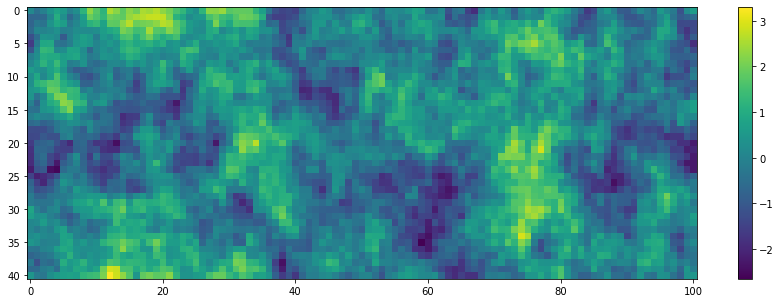

In [9]:
def get_gauss_field():
    k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)

    k3d_x, k3d_y, k3d_z = np.meshgrid(k_x, k_y, k_z, indexing='ij')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    k3d_norm_flat = k3d_norm.flatten()                      # Flatten the k3d array
    idx_sort = np.argsort(k3d_norm_flat)                    # Get the sorting index
    revidx = np.argsort(idx_sort)                           # Index to invert rearange by sorting
    k3d_norm_flat_sort = np.sort(k3d_norm_flat)             # Sort the k array
    P3d_flat_sort = get_pk3d_in(k3d_norm_flat_sort[1:])
    P3d_flat_sort = P3d_flat_sort                           # Take the unit out
    P3d_flat_sort = np.append(np.array([0]), P3d_flat_sort) # Add P(k=0) = 0 back
    P3d_flat = P3d_flat_sort[revidx]                        # Unsort
    P3d_k_grid = P3d_flat.reshape(Nx,Ny,Nz)                 # Unflatten to k cube

    amplitude =  np.sqrt(P3d_k_grid / (proj_reso*proj_reso*los_reso))
    field = np.random.normal(loc=0, scale=1, size=(Nx,Ny,Nz))
    fftfield = np.fft.fftn(field) * amplitude
    fluctuation_cube = np.real(np.fft.ifftn(fftfield))
    return fluctuation_cube
    
plt.figure(0, figsize=(15,5))
plt.imshow(get_gauss_field()[50,:,:])
plt.colorbar()

# Generate lognormal field

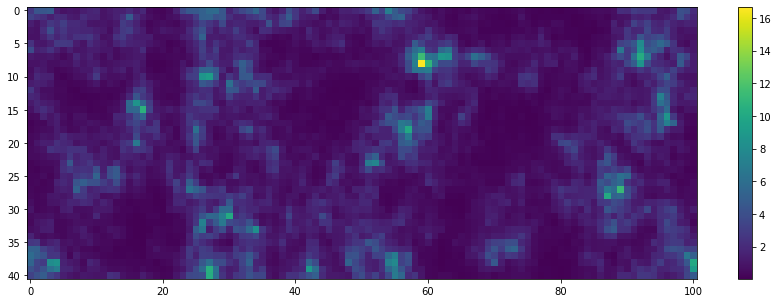

In [21]:
def get_ln_field():
    k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)

    k3d_x, k3d_y, k3d_z = np.meshgrid(k_x, k_y, k_z, indexing='ij')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    k3d_norm_flat = k3d_norm.flatten()                      # Flatten the k3d array
    idx_sort = np.argsort(k3d_norm_flat)                    # Get the sorting index
    revidx = np.argsort(idx_sort)                           # Index to invert rearange by sorting
    k3d_norm_flat_sort = np.sort(k3d_norm_flat)             # Sort the k array
    P3d_flat_sort = get_pk3d_in(k3d_norm_flat_sort[1:])
    P3d_flat_sort = P3d_flat_sort                           # Take the unit out
    P3d_flat_sort = np.append(np.array([0]), P3d_flat_sort) # Add P(k=0) = 0 back
    P3d_flat = P3d_flat_sort[revidx]                        # Unsort
    P3d_k_grid = P3d_flat.reshape(Nx,Ny,Nz)                 # Unflatten to k cube
    
    '''
    P3d_k_grid_b = np.fft.fftn(np.log(np.fft.ifftn(P3d_k_grid)))
    
    plt.figure(10)
    plt.loglog(k3d_norm_flat, P3d_k_grid_b.flatten())
    plt.loglog(k3d_norm_flat, P3d_k_grid.flatten(), marker='o',ls='')
    plt.show()
    '''
    
    amplitude =  np.sqrt(P3d_k_grid / (proj_reso*proj_reso*los_reso))
    field = np.random.normal(loc=0, scale=1, size=(Nx,Ny,Nz))
    fftfield = np.fft.fftn(field) * amplitude
    fluctuation_cube = np.real(np.fft.ifftn(fftfield))
    ln_fluctuation_field = np.exp(fluctuation_cube)
    return ln_fluctuation_field
    
plt.figure(0, figsize=(15,5))
plt.imshow(get_ln_field()[0,:,:])
plt.colorbar()

In [61]:
    k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)

    k3d_x, k3d_y, k3d_z = np.meshgrid(k_x, k_y, k_z, indexing='ij')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    k3d_norm_flat = k3d_norm.flatten()                      # Flatten the k3d array
    idx_sort = np.argsort(k3d_norm_flat)                    # Get the sorting index
    revidx = np.argsort(idx_sort)                           # Index to invert rearange by sorting
    k3d_norm_flat_sort = np.sort(k3d_norm_flat)             # Sort the k array
    P3d_flat_sort = get_pk3d_in(k3d_norm_flat_sort[1:])
    P3d_flat_sort = P3d_flat_sort                           # Take the unit out
    P3d_flat_sort = np.append(np.array([0]), P3d_flat_sort) # Add P(k=0) = 0 back
    P3d_flat = P3d_flat_sort[revidx]                        # Unsort
    P3d_k_grid = P3d_flat.reshape(Nx,Ny,Nz)                 # Unflatten to k cube
    
    N1, N2, N3 = P3d_k_grid.shape

In [67]:
    N1, N2, N3 = P3d_k_grid.shape
    
    if (N1 % 2) == 0: 
        n1 = np.linspace(-N1/2, N1/2-1, N1)
    else:
        n1 = np.linspace(-(N1-1)/2, (N1-1)/2, N1)
        
    if (N2 % 2) == 0: 
        n2 = np.linspace(-N2/2, N2/2-1, N2)
    else:
        n2 = np.linspace(-(N2-1)/2, (N2-1)/2, N2)
        
    if (N3 % 2) == 0: 
        n3 = np.linspace(-N3/2, N3/2-1, N3)
    else:
        n3 = np.linspace(-(N3-1)/2, (N3-1)/2, N3)
    
    x_1 = n1 * proj_reso
    x_2 = n2 * proj_reso
    x_3 = n3 * los_reso
    
    k_1 = n1 / (N1 * proj_reso)
    k_2 = n2 / (N2 * proj_reso)
    k_3 = n3 / (N2 * los_reso)


array([-0.04878049, -0.04780488, -0.04682927, -0.04585366, -0.04487805,
       -0.04390244, -0.04292683, -0.04195122, -0.04097561, -0.04      ,
       -0.03902439, -0.03804878, -0.03707317, -0.03609756, -0.03512195,
       -0.03414634, -0.03317073, -0.03219512, -0.03121951, -0.0302439 ,
       -0.02926829, -0.02829268, -0.02731707, -0.02634146, -0.02536585,
       -0.02439024, -0.02341463, -0.02243902, -0.02146341, -0.0204878 ,
       -0.0195122 , -0.01853659, -0.01756098, -0.01658537, -0.01560976,
       -0.01463415, -0.01365854, -0.01268293, -0.01170732, -0.01073171,
       -0.0097561 , -0.00878049, -0.00780488, -0.00682927, -0.00585366,
       -0.00487805, -0.00390244, -0.00292683, -0.00195122, -0.00097561,
        0.        ,  0.00097561,  0.00195122,  0.00292683,  0.00390244,
        0.00487805,  0.00585366,  0.00682927,  0.00780488,  0.00878049,
        0.0097561 ,  0.01073171,  0.01170732,  0.01268293,  0.01365854,
        0.01463415,  0.01560976,  0.01658537,  0.01756098,  0.01

In [ ]:
def pkrho2pks(pkrho, proj_reso, los_reso):
    N1, N2, N3 = pkrho.shape
    
    if (N1 % 2) == 0: 
        n1 = np.linspace(-N1/2, N1/2-1, N1)
    else:
        n1 = np.linspace(-(N1-1)/2, (N1-1)/2, N1)
        
    if (N2 % 2) == 0: 
        n2 = np.linspace(-N2/2, N2/2-1, N2)
    else:
        n2 = np.linspace(-(N2-1)/2, (N2-1)/2, N2)
        
    if (N3 % 2) == 0: 
        n3 = np.linspace(-N3/2, N3/2-1, N3)
    else:
        n3 = np.linspace(-(N3-1)/2, (N3-1)/2, N3)
    
    x_1 = n1 * proj_reso
    x_2 = n2 * proj_reso
    x_3 = n3 * los_reso
    
    k_1 = n1 / (N1 * proj_reso)
    k_2 = n2 / (N2 * proj_reso)
    k_3 = n3 / (N2 * los_reso)
    
    Vx = proj_reso**2 * los_reso
    Vk = 1 / (N1*N2*N3*Vx)
    
    
    
    
    
    return pks

# Check that the input Pk agrees with output

In [19]:
Nbin = 300
kmin = 0
kmax = None

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


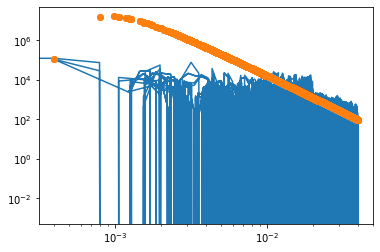

(0.01, 10.0)

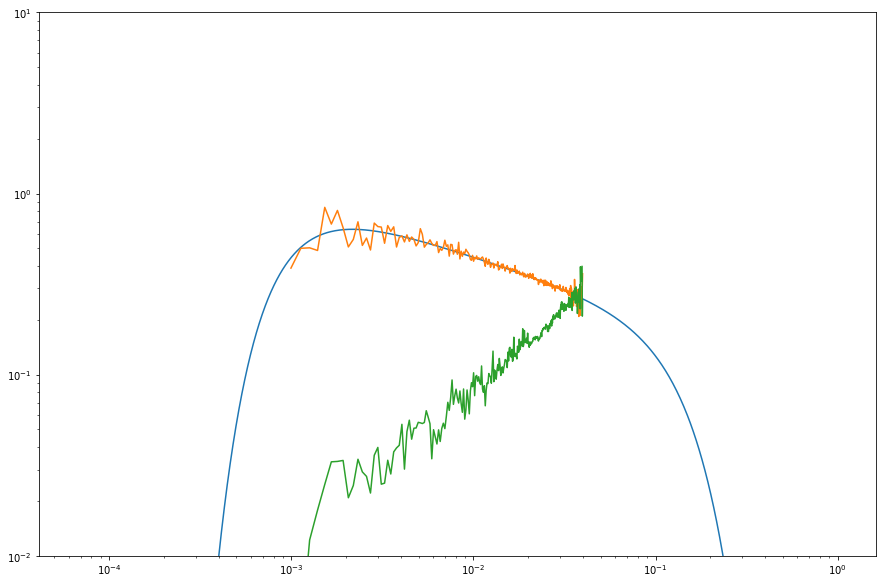

In [20]:
kout, pkout = pitszi.utils_pk.extract_pk3d(get_gauss_field(), proj_reso, los_reso,
                                           Nbin=Nbin, scalebin='lin',
                                           kmin=kmin, kmax=kmax,
                                           statistic='mean')
kout, pkout_ln = pitszi.utils_pk.extract_pk3d(get_ln_field(), proj_reso, los_reso,
                                           Nbin=Nbin, scalebin='lin',
                                           kmin=kmin, kmax=kmax,
                                           statistic='mean')

kin = np.logspace(-4, 0, 1000)
pkin = get_pk3d_in(kin)

plt.figure(0, figsize=(15,10))
plt.loglog(kin, np.sqrt(4*np.pi*kin**3*pkin))
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*pkout))
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*pkout_ln))
plt.ylim(1e-2,1e1)

In [25]:
pkout_mc = np.zeros((100, Nbin))
pkoutln_mc = np.zeros((100, Nbin))
for imc in range(100):
    kout, pkout_i = pitszi.utils_pk.extract_pk3d(get_gauss_field(), proj_reso, los_reso,
                                                 Nbin=Nbin, scalebin='lin', kmin=kmin, kmax=kmax,
                                                 statistic='mean')
    pkout_mc[imc] = pkout_i
    
    kout, pkoutln_i = pitszi.utils_pk.extract_pk3d(get_ln_field(), proj_reso, los_reso,
                                                 Nbin=Nbin, scalebin='lin', kmin=kmin, kmax=kmax,
                                                 statistic='mean')
    pkoutln_mc[imc] = pkoutln_i

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


(0.01, 10.0)

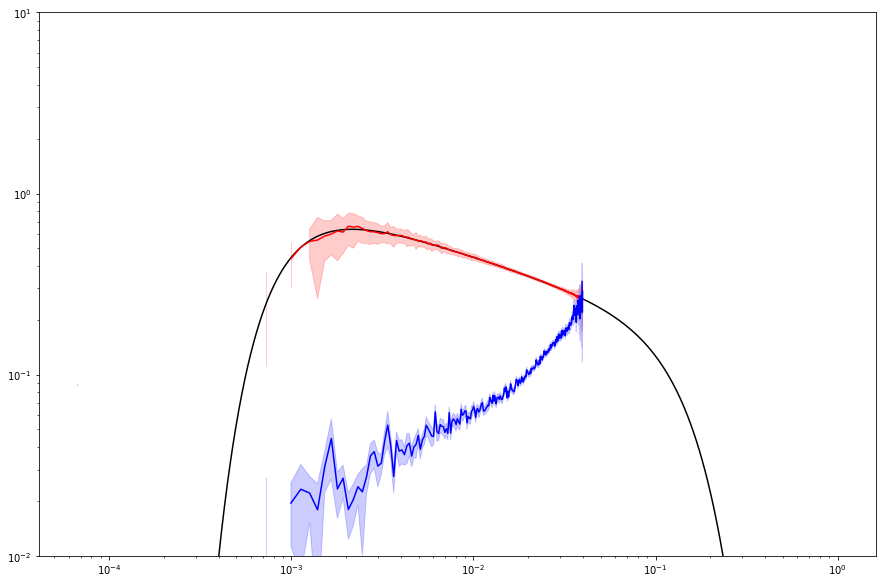

In [26]:
plt.figure(0, figsize=(15,10))
plt.loglog(kin, np.sqrt(4*np.pi*kin**3*pkin), color='k')
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*np.mean(pkout_mc, axis=0)), color='r')
plt.fill_between(kout,
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkout_mc, axis=0)+1*np.std(pkout_mc, axis=0))),
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkout_mc, axis=0)-1*np.std(pkout_mc, axis=0))), 
                 color='r', alpha=0.2)
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*np.mean(pkoutln_mc, axis=0)), color='b')
plt.fill_between(kout,
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkoutln_mc, axis=0)+1*np.std(pkoutln_mc, axis=0))),
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkoutln_mc, axis=0)-1*np.std(pkoutln_mc, axis=0))), 
                 color='b', alpha=0.2)

plt.ylim(1e-2,1e1)

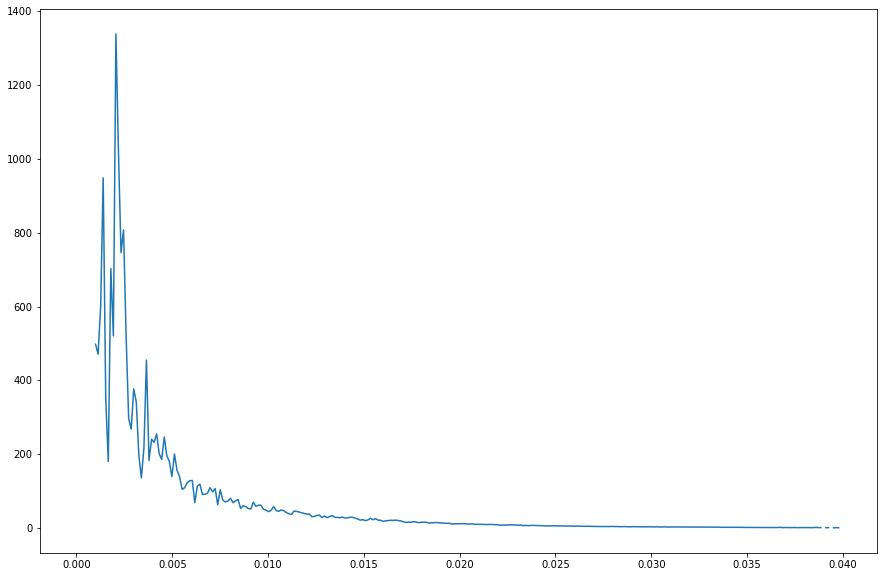

In [27]:
plt.figure(0, figsize=(15,10))
plt.plot(kout, np.mean(pkout_mc, axis=0) / np.mean(pkoutln_mc, axis=0))